In [1]:
import os 
from pathlib import Path
from dotenv import load_dotenv
import pickle
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns

/home/aayush/git/rl_wolpertinger/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
base_path = Path.home()/Path(os.environ.get("SAVE_PATH"))

In [4]:
# loading slateq results
ALPHA = 0.25
SEEDS = [42, 5, 7, 97, 53]
window = 100

In [5]:
def parse_data(data_dict: dict, alg_nam:str, seed: int)->pd.DataFrame:
    # convert from torch to float
    for k, v in data_dict.items():
        if isinstance(v, torch.Tensor):
            data_dict[k] = v.item()
        elif isinstance(v, list):
            if isinstance(v[0], torch.Tensor):
                data_dict[k] = [x.item() for x in v]
    data_df = pd.DataFrame(data_dict)
    data_df["alg_name"] = alg_nam
    data_df["seed"] = seed
    data_df = data_df.reset_index().rename(columns={"index": "episode"})
    data_df["ep_cum_satisfaction_rm_5"] = data_df["ep_cum_satisfaction"].rolling(window=5).mean()
    data_df["ep_cum_satisfaction_rm_10"] = data_df["ep_cum_satisfaction"].rolling(window=10).mean()
    data_df["ep_cum_satisfaction_rm_20"] = data_df["ep_cum_satisfaction"].rolling(window=20).mean()
    data_df["ep_cum_satisfaction_rm_50"] = data_df["ep_cum_satisfaction"].rolling(window=50).mean()
    data_df["ep_cum_satisfaction_rm_100"] = data_df["ep_cum_satisfaction"].rolling(window=100).mean()
    
    return data_df

In [6]:
# load slateq results
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"observed_topic_slateq_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "SlateQ", seed)
    res_df_list.append(res_df)
# concat all results
final_df = pd.concat(res_df_list)

100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


In [7]:
# load wp results
res_df_list = []

for seed in tqdm(SEEDS):
    for knearest in [20, 10, 5]:
        slateq_dict = pickle.load(open(base_path / Path(f"observed_topic_wa_{knearest}_slateq_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
        res_df = parse_data(slateq_dict, f"Slate-Wolpertinger {knearest}%", seed)
        res_df_list.append(res_df)
# concat all results
wp_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, wp_df])

100%|██████████| 5/5 [02:04<00:00, 24.80s/it]


In [8]:
final_df = final_df.reset_index(drop=True)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the plot style to "ticks"
sns.set_style("whitegrid", {"grid.linestyle": "--", "axes.edgecolor": "gray"})

n = 50

# Create a new DataFrame that only contains every n-th row of the original DataFrame
new_df = final_df[final_df['episode'] % n == 0]

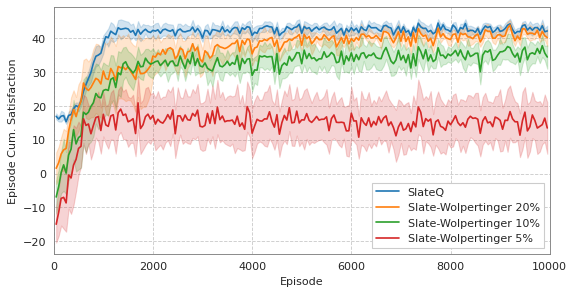

In [17]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=80)
# Plot the mean of ep_cum_satisfaction across different seeds for each alg_name
sns.lineplot(x="episode", y="ep_cum_satisfaction_rm_50", hue="alg_name", errorbar="se", data=new_df)

legend = plt.legend(title='', fancybox=False)
legend.get_frame().set_alpha(None)

# Add a title and axes labels
plt.xlim(0, 10000)
plt.xlabel("Episode")
plt.ylabel("Episode Cum. Satisfaction")
plt.show()


In [11]:
sq_return = final_df.groupby(["alg_name", "seed"]).mean()["session_length"]["SlateQ"].values*4
wp_return = final_df.groupby(["alg_name", "seed"]).mean()["session_length"]["Slate-Wolpertinger 20%"].values*4

In [12]:
from scipy.stats import levene
from scipy.stats import shapiro

print(levene(sq_return, wp_return))
differences = [a-b for a,b in zip(sq_return, wp_return)]
print(shapiro(differences))


LeveneResult(statistic=0.8768810197276957, pvalue=0.3764602611764288)
ShapiroResult(statistic=0.8287601470947266, pvalue=0.1361691653728485)


In [13]:
# hypothesis satisfied for paired t-test on sq and wp return
from scipy.stats import ttest_rel
ttest_rel(sq_return, wp_return)

Ttest_relResult(statistic=0.09640457772453133, pvalue=0.9278362211696938)

In [14]:
# compute wilcoxon signed rank test
# from scipy.stats import wilcoxon
# wilcoxon(sq_return, wp_return)